In [2]:
import json
import cv2
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self):
        self.data = []
        with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
            images = f['images'][:]
            labels = f['labels'][:]
            for i in range(len(images)):
                newimg=np.transpose(images[i], (2, 1, 0))
                newlabel=np.transpose(labels[i], (1, 0))
                new_width = newimg.shape[1] // 2
                new_height = newimg.shape[0] // 2  
                self.data.append({
                    'image': cv2.resize(newimg, (256,256)),
                    'label': cv2.resize(newlabel, (256, 256)) ,
                    'prompt': 'An indoors design'
                })
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        source = item['label']
        target = item['image']
        prompt = item['prompt']

        # source = cv2.imread('./training/fill50k/' + source_filename)
        # target = cv2.imread('./training/fill50k/' + target_filename)

        # Do not forget that OpenCV read images in BGR order.
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Normalize source images to [0, 1].
        source = source.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1].
        target = (target.astype(np.float32) / 127.5) - 1.0

        return {'jpg': target, 'txt': prompt, 'hint': source}

/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
def save_dataset_to_folders(base_dir="output"):

    dataset=MyDataset()
    # Create base directories if they don't exist
    test_dir = os.path.join(base_dir, "test")
    train_dir = os.path.join(base_dir, "train")
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(train_dir, exist_ok=True)

    # Iterate through the dataset and save images
    for idx in range(len(dataset)):
        # Get the sample
        sample = dataset[idx]
        image = sample['jpg']  # Target image
        hint = sample['hint']  # Source image
        prompt = sample['txt']  # Prompt text

        # Determine destination folder
        if idx < 100:
            folder = test_dir
        else:
            folder = train_dir

        # Save the images
        target_path = os.path.join(folder, f"image_{idx:04d}.jpg")
        hint_path = os.path.join(folder, f"hint_{idx:04d}.jpg")
        prompt_path = os.path.join(folder, f"prompt_{idx:04d}.txt")

        # Save images as files
        cv2.imwrite(target_path, (image + 1) * 127.5)  # De-normalize to [0, 255]
        cv2.imwrite(hint_path, hint * 255.0)  # De-normalize to [0, 255]

        # Save the prompt text
        with open(prompt_path, 'w') as f:
            f.write(prompt)

        # Optionally, print progress
        if idx % 10 == 0:
            print(f"Processed {idx}/{len(dataset)} images.")

    print("Dataset saving complete.")
save_dataset_to_folders()

Processed 0/1449 images.
Processed 10/1449 images.
Processed 20/1449 images.
Processed 30/1449 images.
Processed 40/1449 images.
Processed 50/1449 images.
Processed 60/1449 images.
Processed 70/1449 images.
Processed 80/1449 images.
Processed 90/1449 images.
Processed 100/1449 images.
Processed 110/1449 images.
Processed 120/1449 images.
Processed 130/1449 images.
Processed 140/1449 images.
Processed 150/1449 images.
Processed 160/1449 images.
Processed 170/1449 images.
Processed 180/1449 images.
Processed 190/1449 images.
Processed 200/1449 images.
Processed 210/1449 images.
Processed 220/1449 images.
Processed 230/1449 images.
Processed 240/1449 images.
Processed 250/1449 images.
Processed 260/1449 images.
Processed 270/1449 images.
Processed 280/1449 images.
Processed 290/1449 images.
Processed 300/1449 images.
Processed 310/1449 images.
Processed 320/1449 images.
Processed 330/1449 images.
Processed 340/1449 images.
Processed 350/1449 images.
Processed 360/1449 images.
Processed 37

In [5]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, base_dir="output/train"):

        self.data = []

        # Collect all image and prompt paths
        for filename in os.listdir(base_dir):
            if filename.endswith(".jpg") and filename.startswith("image_"):
                # Extract the index from the filename
                idx = filename.split("_")[1].split(".")[0]

                # Get corresponding hint and prompt paths
                image_path = os.path.join(base_dir, f"image_{idx}.jpg")
                hint_path = os.path.join(base_dir, f"hint_{idx}.jpg")
                prompt_path = os.path.join(base_dir, f"prompt_{idx}.txt")

                # Check if all required files exist
                if os.path.exists(image_path) and os.path.exists(hint_path) and os.path.exists(prompt_path):
                    self.data.append({
                        'image_path': image_path,
                        'hint_path': hint_path,
                        'prompt_path': prompt_path
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load the image and hint from disk
        image = cv2.imread(item['image_path'], cv2.IMREAD_COLOR)
        hint = cv2.imread(item['hint_path'], cv2.IMREAD_COLOR)

        # Load the prompt
        with open(item['prompt_path'], 'r') as f:
            prompt = f.read()

        # Normalize images
        image = (image.astype(np.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
        hint = hint.astype(np.float32) / 255.0  # Normalize to [0, 1]

        return {'jpg': image, 'txt': prompt, 'hint': hint}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1349
An indoors design
(256, 256, 3)
(256, 256, 3)


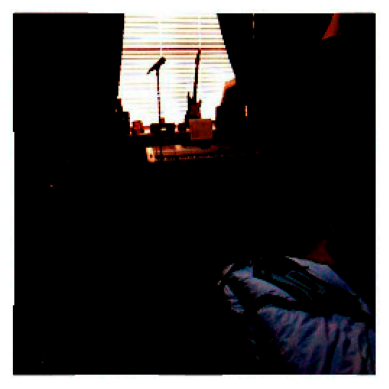

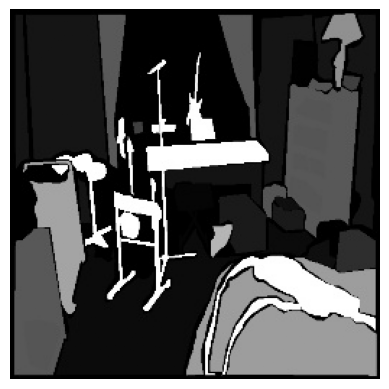

In [6]:
import matplotlib.pyplot as plt
dataset = MyDataset()
print(len(dataset))

item = dataset[10]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
print(txt)
print(jpg.shape)
print(hint.shape)

plt.imshow(jpg, cmap='gray' if jpg.ndim == 2 else None)
plt.axis('off')  # Turn off axis labels for a cleaner display
plt.show()

plt.imshow(hint, cmap='gray' if hint.ndim == 2 else None)
plt.axis('off')  # Turn off axis labels for a cleaner display
plt.show()

In [7]:
import pytorch_lightning as pl
import csv
from pytorch_lightning.callbacks import Callback

class LossLoggerCallback(Callback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Log the loss at each training batch end
        loss = outputs['loss'].detach().cpu().item()  # Make sure to detach from the graph
        self.losses.append(loss)

    def on_train_end(self, trainer, pl_module):
        # Save the loss history to a CSV file at the end of training
        with open('./training_losses64v2.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Step', 'Loss'])
            for i, loss in enumerate(self.losses):
                writer.writerow([i, loss])
        print("Training losses saved to './training_losses.csv'")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
from share import *

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from cldm.logger import ImageLogger
from cldm.model import create_model, load_state_dict
from pytorch_lightning.callbacks import ModelCheckpoint


# Configs
resume_path = './models/control_sd15_seg.pth'
save_path = './models/64v2_updated_control_sd15_seg.pth'
batch_size = 64
logger_freq = 300
learning_rate = 1e-4
sd_locked = True
only_mid_control = False


# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(resume_path, location='cpu'))
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control
loss_logger_callback = LossLoggerCallback()

checkpoint_callback = ModelCheckpoint(
    dirpath='./models',            
    filename='64v2_updated_control_sd15_seg',
    save_top_k=1                               
)


# Misc
dataset = MyDataset()
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = ImageLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(gpus=1, precision=32, callbacks=[logger,checkpoint_callback,loss_logger_callback],max_epochs=12)


# Train!
trainer.fit(model, dataloader)

logging improved.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_seg.pth]


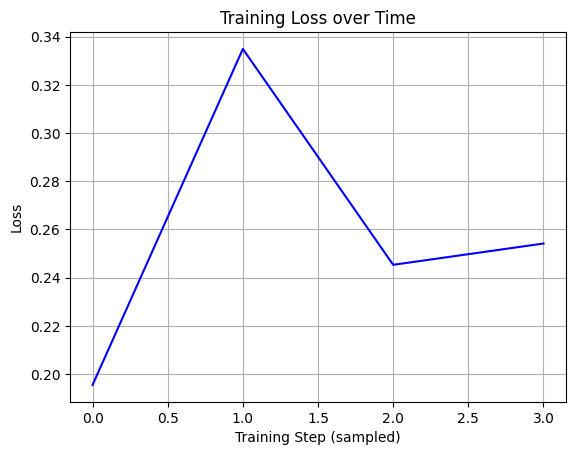

In [14]:
# Sample every 100th point for a cleaner plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the loss data
loss_data = pd.read_csv('./training_losses64.csv')

# Extract only the loss values as an array
ypoints = np.array(loss_data['Loss'])

sampled_ypoints = ypoints[::100]  # Adjust the number to control how many points to skip

plt.plot(sampled_ypoints, linestyle='-', marker='', color='b')  # No marker, just a line
plt.xlabel('Training Step (sampled)')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()


In [15]:
from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.uniformer import UniformerDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

save_path = './models/64_updated_control_sd15_seg.ckpt'
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(save_path, location='cuda'))
model=model.cuda()
ddim_sampler = DDIMSampler(model)
apply_uniformer = UniformerDetector()

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/64_updated_control_sd15_seg.ckpt]
Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /teamspace/studios/this_studio/ControlNet/annotator/ckpts/upernet_global_small.pth


In [16]:
import torch
import random
import einops
import numpy as np
import cv2
import config

def process(input_images, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    results = []
    with torch.no_grad():
        for input_image in input_images:
            # Preprocess the input image
            input_image = HWC3(input_image)
            detected_map = apply_uniformer(resize_image(input_image, detect_resolution))
            img = resize_image(input_image, image_resolution)
            H, W, C = img.shape

            detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

            # Prepare control tensor
            control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
            control = torch.stack([control for _ in range(num_samples)], dim=0)
            control = einops.rearrange(control, 'b h w c -> b c h w').clone()

            # Set the random seed if needed
            if seed == -1:
                seed = random.randint(0, 65535)
            seed_everything(seed)

            # Adjust memory settings if configured
            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)

            # Prepare conditioning and unconditioning
            cond = {
                "c_concat": [control], 
                "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]
            }
            un_cond = {
                "c_concat": None if guess_mode else [control], 
                "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]
            }
            shape = (4, H // 8, W // 8)

            if config.save_memory:
                model.low_vram_shift(is_diffusing=True)

            # Apply control scales
            model.control_scales = ([strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else [strength] * 13)

            # Run sampling
            samples, intermediates = ddim_sampler.sample(
                ddim_steps, num_samples, shape, cond, verbose=False, eta=eta,
                unconditional_guidance_scale=scale,
                unconditional_conditioning=un_cond
            )

            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)

            # Decode the generated samples
            x_samples = model.decode_first_stage(samples)
            x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

            # Take the first generated result from the batch as the single output image
            results.append(x_samples[0])  # Only taking the first image in each batch

    # Return the processed results for each input image
    return results

In [8]:
import os
import cv2

# Define the folder containing the images
input_folder = './output/train'  # Replace with the path to your folder

# List to store loaded images
image_list = []

# Get the list of all files in the folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]  # You can adjust file extensions

# Loop through all image files
for filename in image_files:
    # Construct the full path to the image
    img_path = os.path.join(input_folder, filename)

    # Read the image using OpenCV
    img = cv2.imread(img_path)

    if img is not None:
        # Add the image to the list
        image_list.append(img)
    else:
        print(f"Failed to load image: {img_path}")

# Now image_list contains all the images
print(f"Loaded {len(image_list)} images.")


Loaded 2698 images.


In [17]:
import os
import cv2

# Define the folder containing the images
input_folder = './output/test'  # Replace with the path to your folder

# List to store loaded images
input_images = []

# Get the list of all files in the folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')) and f.startswith('hint')]  # You can adjust file extensions

# Loop through all image files
for filename in image_files:
    # Construct the full path to the image
    img_path = os.path.join(input_folder, filename)
    print(img_path)
    # Read the image using OpenCV
    img = cv2.imread(img_path)

    if img is not None:
        # Add the image to the list
        input_images.append(img)
    else:
        print(f"Failed to load image: {img_path}")


output_images = process(
    input_images, 
    prompt="An indoors design", 
    a_prompt="additional prompt", 
    n_prompt="negative prompt",
    num_samples=1, 
    image_resolution=256, 
    detect_resolution=256, 
    ddim_steps=50, 
    guess_mode=False, 
    strength=1.0, 
    scale=7.5, 
    seed=42, 
    eta=0.0
)

import os
output_folder = '64output_images_segmentation'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through the output images and save them
for idx, image in enumerate(output_images):
    # Define the file path to save the image
    image_path = os.path.join(output_folder, f"output_image_{idx + 1}.png")
    
    # Save the image using OpenCV (assuming the image is in uint8 format)
    cv2.imwrite(image_path, image)
    print(f"Image saved at: {image_path}")

# output_images will contain one processed image for each input image

/teamspace/studios/this_studio/ControlNet/annotator/uniformer/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '
Global seed set to 42


./output/test/hint_0021.jpg
./output/test/hint_0020.jpg
./output/test/hint_0016.jpg
./output/test/hint_0026.jpg
./output/test/hint_0047.jpg
./output/test/hint_0018.jpg
./output/test/hint_0067.jpg
./output/test/hint_0081.jpg
./output/test/hint_0050.jpg
./output/test/hint_0036.jpg
./output/test/hint_0013.jpg
./output/test/hint_0042.jpg
./output/test/hint_0090.jpg
./output/test/hint_0049.jpg
./output/test/hint_0099.jpg
./output/test/hint_0074.jpg
./output/test/hint_0070.jpg
./output/test/hint_0017.jpg
./output/test/hint_0059.jpg
./output/test/hint_0084.jpg
./output/test/hint_0061.jpg
./output/test/hint_0048.jpg
./output/test/hint_0060.jpg
./output/test/hint_0075.jpg
./output/test/hint_0091.jpg
./output/test/hint_0024.jpg
./output/test/hint_0006.jpg
./output/test/hint_0051.jpg
./output/test/hint_0037.jpg
./output/test/hint_0062.jpg
./output/test/hint_0035.jpg
./output/test/hint_0000.jpg
./output/test/hint_0093.jpg
./output/test/hint_0097.jpg
./output/test/hint_0032.jpg
./output/test/hint_0

DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.58it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.57it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.57it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.58it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.58it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.57it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.46it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.46it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.57it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.58it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.58it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.46it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


Image saved at: 64output_images_segmentation/output_image_1.png
Image saved at: 64output_images_segmentation/output_image_2.png
Image saved at: 64output_images_segmentation/output_image_3.png
Image saved at: 64output_images_segmentation/output_image_4.png
Image saved at: 64output_images_segmentation/output_image_5.png
Image saved at: 64output_images_segmentation/output_image_6.png
Image saved at: 64output_images_segmentation/output_image_7.png
Image saved at: 64output_images_segmentation/output_image_8.png
Image saved at: 64output_images_segmentation/output_image_9.png
Image saved at: 64output_images_segmentation/output_image_10.png
Image saved at: 64output_images_segmentation/output_image_11.png
Image saved at: 64output_images_segmentation/output_image_12.png
Image saved at: 64output_images_segmentation/output_image_13.png
Image saved at: 64output_images_segmentation/output_image_14.png
Image saved at: 64output_images_segmentation/output_image_15.png
Image saved at: 64output_images_se